In [10]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from pathlib import Path
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
#Load data
OUTPUT_DIR = Path('../data/processed')
df_train = pd.read_csv(OUTPUT_DIR/'train_data.csv')
df_test = pd.read_csv(OUTPUT_DIR/'test_data.csv')

In [11]:
# Path to baseline results (one level up from notebooks/)
results_path = '../results/baseline_metrics.json'

# Check if file exists
if not os.path.exists(results_path):
    print("Please run 02_baseline_cf.ipynb first to generate baseline metrics.")
    raise FileNotFoundError(f"{results_path} not found")

# Load baseline metrics
with open(results_path, 'r') as f:
    baseline_results = json.load(f)

# Extract values we need
rmse = baseline_results['overall_performance']['rmse']
mae = baseline_results['overall_performance']['mae']
rmse_cold = baseline_results['cold_start_performance']['rmse']
mae_cold = baseline_results['cold_start_performance']['mae']

In [4]:
#checking genre format and number of unique genres
print(df_train['genres'].head())
print(df_train['genres'].nunique())

0         Action|Adventure|Fantasy
1         Action|Drama|Romance|War
2    Action|Adventure|Comedy|Crime
3          Horror|Mystery|Thriller
4    Drama|Horror|Mystery|Thriller
Name: genres, dtype: object
1097


In [5]:
#Building content-based filtering model with TF-IDF and cosine similarity 

#Combining train and test set to get all movies for TF-IDF vocabulary
all_movies = pd.concat([df_train[['movieId', 'genres']], df_test[['movieId', 'genres']]]).drop_duplicates('movieId')

#Missing genres are encoded as 'Unknown'
all_movies['genres'] = all_movies['genres'].fillna('Unknown')

#TF-IDF vectorization   
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'), lowercase=False, token_pattern=None)
genre_matrix = tfidf.fit_transform(all_movies['genres'])

#Create movie_id to index mapping
movie_to_index = {movie_id: index for index, movie_id in enumerate(all_movies['movieId'])} #{movie_id: index}
index_to_movie = {index: movie_id for movie_id, index in movie_to_index.items()} # {index: movie_id}

#Build user profile vectors - weighted average of a user's movie ratings
def build_user_profile(user_id, df_train, genre_matrix, movie_to_index):

    user_ratings = df_train[df_train['userId'] == user_id] 

    if len(user_ratings) == 0:
        return None

    movie_vectors = []
    ratings = []

    for idx, row in user_ratings.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        
        if movie_id in movie_to_index:
            movie_index = movie_to_index[movie_id]
            movie_vector = genre_matrix[movie_index].toarray().flatten()
            movie_vectors.append(movie_vector)
            ratings.append(rating)

    if len(movie_vectors) == 0:
        return None

    #Convert to arrays and normalize 
    movie_vectors = np.array(movie_vectors)
    ratings = np.array(ratings)

    #Normalize ratings to 0-1 range
    min_rating = min(ratings)
    max_rating = max(ratings)
    if max_rating == min_rating:
        weights = np.ones_like(ratings) #if all the ratings are the same, make weights equal
    else:
        weights = (ratings - min_rating) / (max_rating - min_rating) #min-max normalization scale [0,1]

    #Weighted average of movie vectors
    user_profile = np.average(movie_vectors, axis=0, weights=weights)

    return user_profile

            
#Building user profiles for all users
user_profiles = {}
unique_users = df_train['userId'].unique()

for user_id in unique_users:
    user_profile = build_user_profile(user_id, df_train, genre_matrix, movie_to_index)
    if user_profile is not None:
        user_profiles[user_id] = user_profile   


In [6]:
#Making predictions using cosine similarity

user_avg_rating = df_train.groupby('userId')['rating'].mean()
global_mean = df_train['rating'].mean()

def predict_with_similarity(user_id, movie_id, user_profiles, genre_matrix, movie_to_index, user_avg_rating, global_mean):
    
    #Check if user or movie is unknown
    if user_id not in user_profiles or movie_id not in movie_to_index:
        return user_avg_rating.get(user_id, global_mean)

    #Get user profile and movie vector
    user_profile = user_profiles[user_id].reshape(1, -1)
    movie_index = movie_to_index[movie_id]
    movie_vector = genre_matrix[movie_index].toarray().flatten()
    movie_vector = movie_vector.reshape(1, -1)

    #Calculate cosine similarity #ranges from 0 to 1 since all the movie vectors are non-negative
    #similarity of 1.0  = perfect match (user profile is identical to movie genre)
    #similarity of 0.0 = no match (user profile and movie genre are completely different)
    #similarity of 0.5 = average match (user profile and movie genre are somewhat similar)
    similarity = cosine_similarity(user_profile, movie_vector)[0][0]

    #Predict rating
    user_avg = user_avg_rating.get(user_id, global_mean)
    #if similarity is 0.5, no adjustment is made so prediction is equal to user average
    #if similarity is 1.0, positive adjustment is made so prediction is higher than user average
    #if similarity is 0.0, negative adjustment is made so prediction is lower than user average
    adjustment = (similarity - 0.5) * 1.0 

    predicted_rating = user_avg + adjustment
    predicted_rating = np.clip(predicted_rating, 0.5, 5) #clip rating to valid range 

    return predicted_rating



In [12]:
#Cold start movies in the test set

train_movies = df_train['movieId'].unique()
test_movies = df_test['movieId'].unique()
cold_start_movies = set(test_movies) - set(train_movies)

df_test_cold = df_test[df_test['movieId'].isin(cold_start_movies)]

#Predicting ratings for cold start movies

predictions_tfidf_cold = []
actual_rating_cold = []

for idx, row in df_test_cold.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    actualrating = row['rating']
    
    predicted_rating = predict_with_similarity(user_id, movie_id, user_profiles, genre_matrix, movie_to_index, user_avg_rating, global_mean)
    predictions_tfidf_cold.append(predicted_rating)
    actual_rating_cold.append(actualrating)

#Evaluating model performance
rmse_tfidf_cold = np.sqrt(np.mean((np.array(predictions_tfidf_cold) - np.array(actual_rating_cold)) ** 2))
mae_tfidf_cold = np.mean(np.abs(np.array(predictions_tfidf_cold) - np.array(actual_rating_cold)))

print(f"RMSE on cold start movies: {rmse_tfidf_cold:.4f}")
print(f"MAE on cold start movies: {mae_tfidf_cold:.4f}")

if rmse_tfidf_cold < rmse_cold: 
    improvement = (rmse_cold - rmse_tfidf_cold) / rmse_cold * 100
    print(f"Content-based model improves RMSE by {improvement:.2f}%")
else:
    decline = (rmse_tfidf_cold - rmse_cold) / rmse_cold * 100
    print(f"Content-based model worsens RMSE by {decline:.2f}%")



RMSE on cold start movies: 0.8973
MAE on cold start movies: 0.6741
Content-based model worsens RMSE by 7.35%


Prediction Diagnostics
Predictions - Min: 1.54, Max: 4.92, Mean: 3.43
Actuals - Min: 0.50, Max: 5.00, Mean: 3.38

Predictions at 0.5 (minimum): 0.00 %
Predictions at 5.0 (maximum): 0.00 %


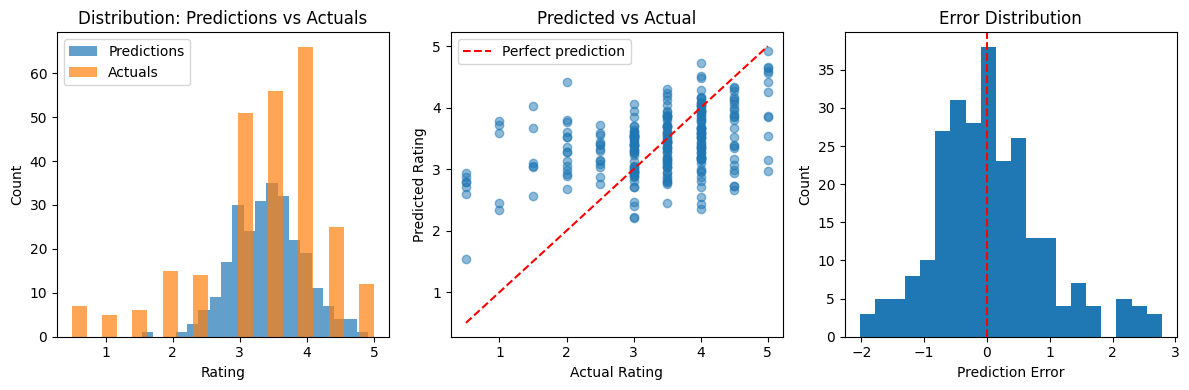

In [15]:
# Diagnostic: Check prediction distribution

predictions_array = np.array(predictions_tfidf_cold)
actuals_array = np.array(actual_rating_cold)

print("Prediction Diagnostics")
print(f"Predictions - Min: {predictions_array.min():.2f}, Max: {predictions_array.max():.2f}, Mean: {predictions_array.mean():.2f}")
print(f"Actuals - Min: {actuals_array.min():.2f}, Max: {actuals_array.max():.2f}, Mean: {actuals_array.mean():.2f}")

# Check how many predictions are at boundaries
at_min = (predictions_array == 0.5).sum()/len(predictions_array)*100
at_max = (predictions_array == 5.0).sum()/len(predictions_array)*100
print(f"\nPredictions at 0.5 (minimum): {at_min:.2f} %")
print(f"Predictions at 5.0 (maximum): {at_max:.2f} %")

# Plot distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(predictions_array, bins=20, alpha=0.7, label='Predictions')
plt.hist(actuals_array, bins=20, alpha=0.7, label='Actuals')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution: Predictions vs Actuals')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(actuals_array, predictions_array, alpha=0.5)
plt.plot([0.5, 5.0], [0.5, 5.0], 'r--', label='Perfect prediction')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs Actual')
plt.legend()

plt.subplot(1, 3, 3)
errors = predictions_array - actuals_array
plt.hist(errors, bins=20)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()

#Save plots in results folder
plt.savefig('../results/content_based_diagnostics.png')

plt.show()



RESULTS AND INTERPRETATION:

Performance on Cold Start Movies (100 movies, 257 test ratings):
- Baseline SVD Model: RMSE = 0.8359, MAE = 0.6353
- Content-Based (TF-IDF + Cosine Similarity): RMSE = 0.8973, MAE = 0.6741
- Result: Content-based performed 7.35% worse than baseline

Why the Content-Based Model Underperformed:
1) Limited Feature Space: predictions were made based on similarities to the user's genre preferences. The model underperformed because genre information alone (20 categories) does not capture nuanced factors that influence user movie preferences. These factors include cast, director, cinematography, production value, thematic depth..etc. Using only genre labels loses critical information.

2) Quality Blindness: the content-based model does not account for the difference in the quality of the movies within the same genre. If a user prefers Sci-fi|Action movies, the model will not differentiate between a high-quality and low-quality Sci-fi|Action movie. Both will have the same similarity score and will be rated highly, despite potentially vast differences in actual user satisfaction.

3) Regression to Mean — the weighted averaging approach and cosine similarity naturally produce predictions clustering in the 3.0-4.5 range. The model struggles to confidently predict very low ratings (<2.0) or perfect scores (5.0), compressing its prediction range and reducing ability to match the full spectrum of actual ratings.

Baseline SVD Model Advantage:
1) Learns latent representations beyond explicit features
2) Captures user biases, for example, User A rates +0.5 stars above average
3) Discovers patterns, for example, users who liked X also liked Y (even across genres)
4) Item popularity/ quality signals embedded in learned factors

Diagnostic Insights:
- Predictions are well-distributed (predicted mean: 3.43 vs actual mean: 3.38)
- No systematic bias (erros centered around zero)
- High variance in predictions (wide scatter around the actual values)
- Difficulty predicting extremes (ratings below 2.0 and perfect 5.0 scores)

Implications and Next Steps:
These findings suggest that a hybrid approach combining collaborative filtering with richer content features (cast, director, user reviews, movie metadata) or neural collaborative filtering would better handle cold-start scenarios.
